In [55]:
import pyshark
import pandas as pd
import nest_asyncio

nest_asyncio.apply()

def extract_packet_features(pcap_file, camera_ip):
    cap = pyshark.FileCapture(pcap_file, display_filter="ip")
    packet_features = []

    print(f"Processing PCAP file: {pcap_file}")

    try:
        for packet in cap:
            # Exclude multicast traffic
            if packet.ip.dst.startswith("224.") or packet.ip.src.startswith("224."):
                continue

            try:
                src_ip = packet.ip.src
                dst_ip = packet.ip.dst
                length = int(packet.length)
                src_port = int(packet[packet.transport_layer].srcport) if hasattr(packet, "transport_layer") else 0
                dst_port = int(packet[packet.transport_layer].dstport) if hasattr(packet, "transport_layer") else 0
                protocol = packet.highest_layer

                # Identify if the packet is STUN
                is_stun = 1 if protocol.lower() == "stun" else 0

                # Assign label based on camera IP
                label = 1 if src_ip == camera_ip or dst_ip == camera_ip else 0

                packet_features.append({
                    "src_ip": src_ip,
                    "dst_ip": dst_ip,
                    "length": length,
                    "src_port": src_port,
                    "dst_port": dst_port,
                    "is_stun": is_stun,
                    "label": label,
                })
            except AttributeError:
                continue
    finally:
        cap.close()

    return pd.DataFrame(packet_features)

# Example usage: Extract features from multiple PCAP files with mixed traffic
camera_ip = "192.168.1.169"  # Replace with your actual camera IP
pcap_files = [
    "training_packets/new_capture.pcap",
    # "training_packets/idle.pcap",
    # "training_packets/motionDetection.pcap",
    # "training_packets/livestream.pcap",
]

all_features = []
for pcap_file in pcap_files:
    features = extract_packet_features(pcap_file, camera_ip)
    all_features.append(features)

# Combine all features into one DataFrame
df_combined_features = pd.concat(all_features, ignore_index=True)
df_combined_features.to_csv("all_features.csv", index=False)
print("Combined packet-level features saved to all_features.csv")

Processing PCAP file: training_packets/new_capture.pcap


Task exception was never retrieved
future: <Task finished name='Task-826625' coro=<TsharkXmlParser.get_packets_from_stream() done, defined at /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pyshark/tshark/output_parser/tshark_xml.py:24> exception=KeyboardInterrupt()>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3548, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/nk/_9k47c0175s8pp3608y62yyh0000gn/T/ipykernel_29483/3586198981.py", line 60, in <module>
    features = extract_packet_features(pcap_file, camera_ip)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/nk/_9k47c0175s8pp3608y62yyh0000gn/T/ipykernel_29483/3586198981.py", line 14, in extract_packet_features
    for packet in cap:
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packag

Combined packet-level features saved to all_features.csv


In [56]:
def aggregate_flows(df):
    grouped = df.groupby(["src_ip", "dst_ip", "src_port", "dst_port"]).agg(
        total_packets=("length", "count"),
        avg_packet_length=("length", "mean"),
        std_packet_length=("length", "std"),
        stun_packet_ratio=("is_stun", "mean"),  # Ratio of STUN packets in the flow
        label=("label", lambda x: x.mode()[0] if not x.mode().empty else 0),  # Most common label in the flow
    ).reset_index()

    return grouped


# Load combined packet-level features
df_combined = pd.read_csv("all_features.csv")

# Aggregate flow-level features
df_flows_combined = aggregate_flows(df_combined)
df_flows_combined.to_csv("all_flows.csv", index=False)
print("Combined flow-level features saved to all_flows.csv")

Combined flow-level features saved to all_flows.csv


In [117]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import joblib

# Load the flow-level features
df_flows_combined = pd.read_csv("all_flows.csv")

# Prepare features and labels for training
features = df_flows_combined[["src_port","dst_port","total_packets", "avg_packet_length", "std_packet_length", "stun_packet_ratio"]].fillna(0)
labels = df_flows_combined["label"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Train the model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Evaluate the model
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

# Save the model
joblib.dump(clf, "camera_detector_model_v2.pkl")
print("Updated model saved as camera_detector_model_v2.pkl")

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       607
           1       0.98      0.99      0.98        83

    accuracy                           1.00       690
   macro avg       0.99      0.99      0.99       690
weighted avg       1.00      1.00      1.00       690

Updated model saved as camera_detector_model_v2.pkl


In [135]:
def test_model_with_ranking(pcap_file, model_path, top_n=2):
    # Extract packet-level features
    df_test = extract_packet_features(pcap_file, camera_ip="192.168.1.169")  # Use the same camera IP as before
    if df_test.empty:
        print("No packets extracted. Exiting.")
        return pd.DataFrame()

    # Aggregate flows
    df_test_agg = aggregate_flows(df_test)
    if df_test_agg.empty:
        print("No flows aggregated. Exiting.")
        return pd.DataFrame()

    # Load the model
    clf = joblib.load(model_path)

    # Predict probabilities for camera traffic
    features = df_test_agg[["src_port","dst_port","total_packets", "avg_packet_length", "std_packet_length", "stun_packet_ratio"]].fillna(0)
    probabilities = clf.predict_proba(features)

    # Add prediction probabilities and sort by likelihood of being camera traffic
    df_test_agg["camera_probability"] = probabilities[:, 1]
    ranked_results = df_test_agg.sort_values(by="camera_probability", ascending=False)

    # Return the top N potential camera IPs
    top_camera_ips = ranked_results["src_ip"].head(top_n).unique()
    print(f"Top {top_n} detected camera IPs: {top_camera_ips}")

    return ranked_results

# Test the model with ranking
test_pcap_file = "training_packets/motionDetection.pcap"
model_path = "camera_detector_model_v2.pkl"
df_ranked_results = test_model_with_ranking(test_pcap_file, model_path, top_n=3)
df_ranked_results.to_csv("ranked_test_results.csv", index=False)
print("Ranked test results saved to ranked_test_results.csv")

Processing PCAP file: training_packets/motionDetection.pcap
Top 3 detected camera IPs: ['192.168.1.169' '192.168.1.1']
Ranked test results saved to ranked_test_results.csv


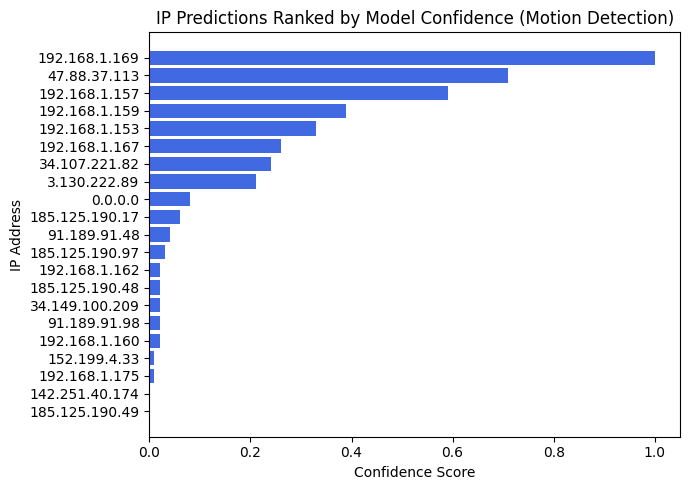

In [137]:
import pandas as pd
import matplotlib.pyplot as plt

# Replace this path with the actual path to your CSV file
file_path = "ranked_test_results.csv"

# Read the CSV file
df_ranked_results = pd.read_csv(file_path)

# List of IPs to ignore
ignore_ips = ["192.168.1.1", "8.8.8.8", "8.8.4.4", "34.107.243.93", "35.162.166.139", "3.13.9.245", "18.219.242.42", "44.226.105.112", "3.129.225.126", "34.210.246.156"]
# ignore_ips = []


# Filter out ignored IPs
df_filtered = df_ranked_results[~df_ranked_results['src_ip'].isin(ignore_ips)]

# Sort by camera probability
df_ranked_sorted = df_filtered.sort_values(by='camera_probability', ascending=False)

# Select top N IPs
top_n = 200
df_top_ips = df_ranked_sorted.head(top_n)

# Plotting the ranked probabilities
plt.figure(figsize=(7, 5))
plt.barh(df_top_ips['src_ip'], df_top_ips['camera_probability'], color='royalblue')
plt.xlabel('Confidence Score')
plt.ylabel('IP Address')
plt.title('IP Predictions Ranked by Model Confidence (Motion Detection)')
plt.gca().invert_yaxis()  # Invert y-axis to show the highest probability at the top
plt.tight_layout()

# Show the plot
plt.show()

6


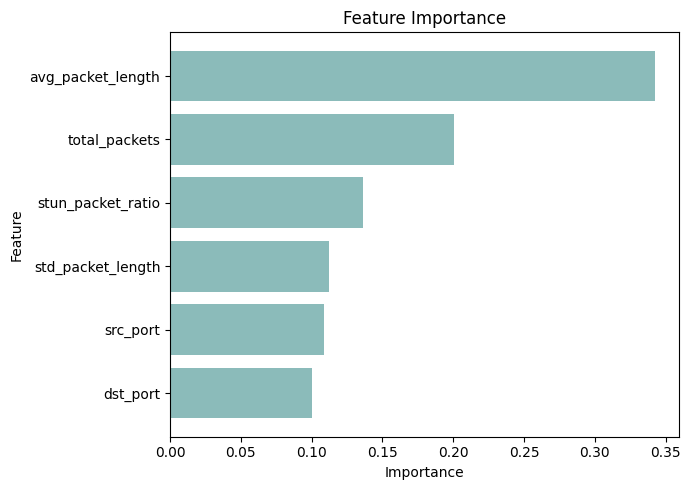

In [143]:
import joblib
import pandas as pd
import matplotlib.pyplot as plt

# Load the trained Random Forest model
model_path = "camera_detector_model_v2.pkl"  # Replace with your model path
clf = joblib.load(model_path)

# Define the feature names (ensure they match the training features)
feature_names = ["src_port","dst_port","total_packets","avg_packet_length","std_packet_length","stun_packet_ratio"]

# Get feature importances from the model
feature_importances = clf.feature_importances_
print(len(feature_importances))
# Create a DataFrame for better visualization
df_feature_importance = pd.DataFrame({
    "Feature": feature_names,
    "Importance": feature_importances
}).sort_values(by="Importance", ascending=False)

# Plot the feature importances
plt.figure(figsize=(7, 5))
plt.barh(df_feature_importance["Feature"], df_feature_importance["Importance"], color="#8bbbba")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance")
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
plt.tight_layout()

# Show the plot
plt.show()